## Imports and config

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')

import config as cfg

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

## Load train data

In [2]:
X_train = pd.read_csv(cfg.FILENAMES["X_TRAIN"],)
X_train["date"] = pd.to_datetime(X_train["date"])
print(len(X_train))
X_train.head()

1609124


,Unnamed: 0,date_block_num,shop_id,item_id,date,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,0,32,2013-01-03,221.0,6.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,1,0,0,33,2013-01-03,347.0,3.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,2,0,0,35,2013-01-31,247.0,1.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,3,0,0,43,2013-01-31,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,4,0,0,51,2013-01-13,128.5,2.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


## Aggregate to year level

In [3]:
X_year = (X_train.groupby("date_block_num")
         .agg({"date":"min", "item_cnt_month":"sum"})
         .reset_index())
X_year.head()

,date_block_num,date,item_cnt_month
0,0,2013-01-01,131479.0
1,1,2013-02-01,128090.0
2,2,2013-03-01,147142.0
3,3,2013-04-01,107190.0
4,4,2013-05-01,106970.0


/Users/robinblanchard/Desktop/training/kaggle-predict-future-sales/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


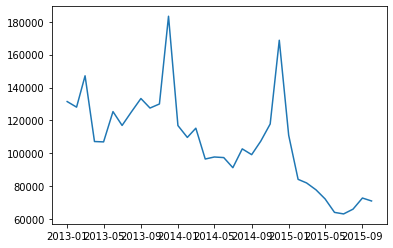

In [4]:
plt.plot(X_year["date"],X_year["item_cnt_month"])

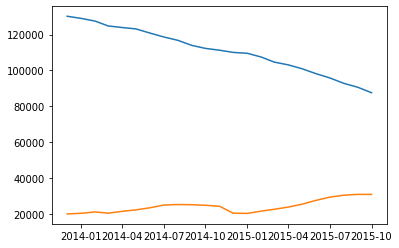

In [5]:
plt.plot(X_year["date"],X_year["item_cnt_month"].rolling(12).mean())
plt.plot(X_year["date"],X_year["item_cnt_month"].rolling(12).std())

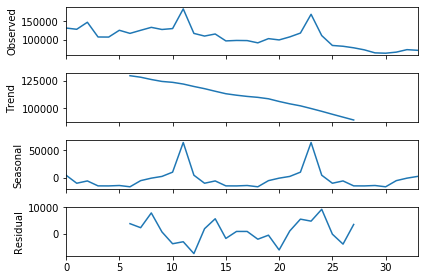

In [6]:
seasonal_decompose(X_year["item_cnt_month"], freq=12).plot()
plt.show()

Recap : strong seasonality, with a decreasing trend

#### Is it stationary?

Dickey-Fuller test  
Null Hypothesis: There is a unit root -> Non-stationary  
Alternate Hypothesis : There is no unit root -> Stationary  

In [7]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [8]:
test_stationarity(X_year["item_cnt_month"])

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


P-value>14% so we fail to reject the null hypothesis at a 10% confidence level but we can at a 15% confidence level  
Data is not stationary  
Hence, we need to make a transformation of our data -> difference

In [9]:
X_year["c_item_cnt_month"]=X_year["item_cnt_month"].diff()
X_year.head()

,date_block_num,date,item_cnt_month,c_item_cnt_month
0,0,2013-01-01,131479.0,NaN
1,1,2013-02-01,128090.0,-3389.0
2,2,2013-03-01,147142.0,19052.0
3,3,2013-04-01,107190.0,-39952.0
4,4,2013-05-01,106970.0,-220.0


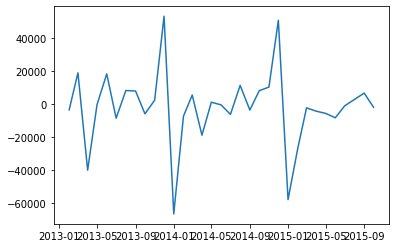

In [10]:
plt.plot(X_year["date"],X_year["c_item_cnt_month"])

In [11]:
test_stationarity(X_year["c_item_cnt_month"])

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


P-value ~ 0 so we can reject the null hypothesis that there is a unit root. Hence, there is no unit root so data is stationary

But still, there is seasonality

In [12]:
X_year["c_item_cnt_month"]=X_year["item_cnt_month"].diff(periods=12)
X_year.head()

,date_block_num,date,item_cnt_month,c_item_cnt_month
0,0,2013-01-01,131479.0,NaN
1,1,2013-02-01,128090.0,NaN
2,2,2013-03-01,147142.0,NaN
3,3,2013-04-01,107190.0,NaN
4,4,2013-05-01,106970.0,NaN


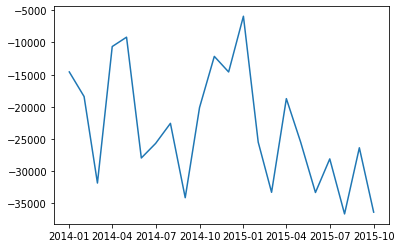

In [13]:
plt.plot(X_year["date"],X_year["c_item_cnt_month"])

In [14]:
test_stationarity(X_year["c_item_cnt_month"])

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


P-value ~ 0 so we can reject the null hypothesis that there is a unit root. Hence, there is no unit root so data is stationary

In [58]:
train = X_year[["date","c_item_cnt_month"]].dropna()
train.index = train["date"]
train.head(2)

,date,c_item_cnt_month
date,,
2014-01-01,2014-01-01,-14580.0
2014-02-01,2014-02-01,-18403.0


In [67]:
test = train.iloc[-5:]
train = train.iloc[:-5]
test

,date,c_item_cnt_month
date,,
2015-01-01,2015-01-01,-5928.0
2015-02-01,2015-02-01,-25489.0
2015-03-01,2015-03-01,-33283.0
2015-04-01,2015-04-01,-18729.0
2015-05-01,2015-05-01,-25495.0


## AR and MA models

#### AR

In [60]:
def ar_model(df, col_to_predict):
    lags = range(1,7)
    best_model= None
    best_aic = np.inf
    for l in lags:
        ar_model = AR(df[col_to_predict], dates = df["date"])
        ar_model = ar_model.fit(maxlag=l, method="mle", ic="aic", trend="nc")
        
        ar_aic = ar_model.aic
        if ar_aic < best_aic:
            best_aic = ar_aic
            best_model = ar_model
    
    print(f"Best AIC : {best_aic}")
    print(f'Lag: {best_model.k_ar}')
    print('Coefficients: %s' % best_model.params)
    
    return best_model


In [61]:
ar_res = ar_model(train, "c_item_cnt_month")

Best AIC : 18.729548686155617
Lag: 3
Coefficients: L1.c_item_cnt_month    0.548499
L2.c_item_cnt_month   -0.119375
L3.c_item_cnt_month    0.529071
dtype: float64


In [64]:
ar_res.predict(test.index[0], test.index[-1], dynamic = True)

2015-06-01   -29357.281389
2015-07-01   -22967.937406
2015-08-01   -22582.026199
2015-09-01   -25176.507990
2015-10-01   -23265.226651
Freq: MS, dtype: float64

In [75]:
def fit_predict(train, test, col_to_predict, model):
    print(str(model))
    res = model(train, col_to_predict)
    
    predictions = res.predict(test.index[0], test.index[-1], dynamic = True)
    
    plt.figure(figsize = (7,7))
    plt.plot(train["date"], train[col_to_predict], color="blue")
    plt.plot(test["date"], test[col_to_predict], color="blue")
    plt.plot(test["date"], predictions, color="orange")
    plt.show()

<function ar_model at 0x123170a60>
Best AIC : 18.560875770501802
Lag: 5
Coefficients: L1.c_item_cnt_month    1.034850
L2.c_item_cnt_month   -0.663510
L3.c_item_cnt_month    0.957609
L4.c_item_cnt_month   -0.877400
L5.c_item_cnt_month    0.510666
dtype: float64


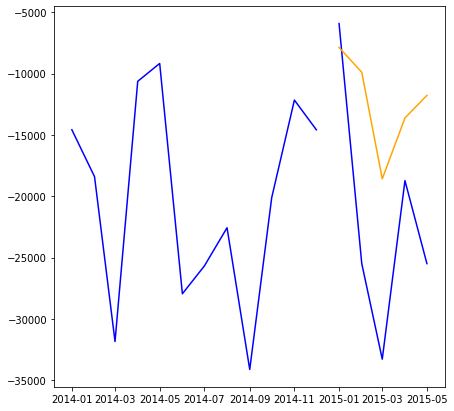

In [76]:
fit_predict(train, test, "c_item_cnt_month", ar_model)

## ARMA

In [89]:
def arma_model(df, col_to_predict):
    ar_params = range(5)
    ma_params = range(5)
    
    best_model= None
    best_aic = np.inf
    for p in ar_params:
        for q in ma_params:
            if p!=0 or q!=0:
                try:
                    arma_model = smt.ARMA(df[col_to_predict], order=(p, q)).fit(method='mle', trend='nc')

                    arma_aic = arma_model.aic
                    if arma_aic < best_aic:
                        best_aic = arma_aic
                        best_model = arma_model
                except:
                    continue
    
    print(f"Best AIC : {best_aic}")
    print(f'AR Lag: {best_model.k_ar}')
    print(f'MA Coeff: {best_model.k_ma}')
    print('Coefficients: %s' % best_model.params)
    
    return best_model


In [90]:
armaarma_model(train, "c_item_cnt_month")

Best AIC : 260.9259126198035
AR Lag: 3
MA Coeff: 2
Coefficients: ar.L1.c_item_cnt_month   -0.016120
ar.L2.c_item_cnt_month   -0.063927
ar.L3.c_item_cnt_month    0.905977
ma.L1.c_item_cnt_month    1.392194
ma.L2.c_item_cnt_month    0.999483
dtype: float64


<function arma_model at 0x1240ff730>
Best AIC : 260.9259126198035
AR Lag: 3
MA Coeff: 2
Coefficients: ar.L1.c_item_cnt_month   -0.016120
ar.L2.c_item_cnt_month   -0.063927
ar.L3.c_item_cnt_month    0.905977
ma.L1.c_item_cnt_month    1.392194
ma.L2.c_item_cnt_month    0.999483
dtype: float64


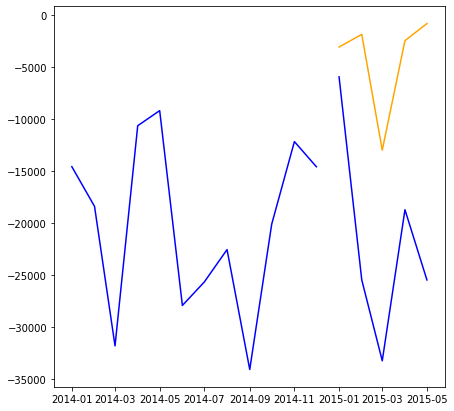

In [91]:
fit_predict(train, test, "c_item_cnt_month", arma_model)